# Introduction to deep learning for computer vision

## Import packages

In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

## Import MNIST DataSet

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Do some sanity check on the data**
- what is the shape of train and test set and the corresponding labels?
- How many data points are there in train and test set?
- Print a sample data point from train
- show the sample datapoint with `imshow` (pass cmap="gray" argument to see the image in black and white)  

In [ ]:
#TODO: your sanity checks for imported dataset

## Data preprocessing

In [ ]:
# Reshape the training images to have a shape of (60000, 28, 28, 1),
# where 60000 is the number of images,
# 28x28 is the image size,
# and 1 represents the single color channel (grayscale).
train_images = train_images.reshape((60000, 28, 28, 1))

# Convert pixel values from integers (0-255) to floating-point numbers (0.0-1.0)
# for better model performance.
train_images = train_images.astype("float32") / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

## Part A: Introduction to convnets

**Instantiating a small convnet**
We can instantiate the model in TensorFlow in two ways.




**Approach 1: Sequential API**

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

**Approach 2: Functioanl API**
- In Keras' functional API, each layer acts like a function that transforms an `input` tensor.
- When you pass inputs through multiple layers, Keras records the entire sequence of transformations.
- `model = keras.Model(inputs, outputs)` connects the dots, forming a complete model from `inputs` to `outputs`.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# each layer acts like a function
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=5, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Sequential API is easier however with functioal API non-Sequential Connections Allowed: You can create models with branches, residual connections (like ResNet), or multi-input/multi-output structures.

**Visualizing the conv operarion 3-chanel images**
- image size = (5 x 5 x 3)
- kernel_size = 3
- stride = 1
- padding = no padding

In [ ]:
from IPython.display import display, HTML

gif_url = "https://raw.githubusercontent.com/PyDataGBC/PyML2025/main/LabWeek11/assets/Conv2d_0p_1s_3inCh.gif"
display(HTML(f'<img src="{gif_url}" width="600" height="400">'))  # Adjust size as needed

**Displaying the model's summary**

In [ ]:
model.summary()

![](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek11/assets/image.png)

**Instantiate your own model with the following architecture and then display the summary of the model**

- Input layer
- Conv2D with `filter`=32 and `kernel_size`=3
- MaxPooling2d with `pool_size`=2
- Conv2D with `filter`=64 and `kernel_size`=3
- MaxPooling2d with `pool_size`=2
- Conv2D with `filter`=128 and `kernel_size`=3
- Flatten layer
- Output layer (for 10 classes)

**Note:** Use functioal API to define your model


In [ ]:
#your code here

In [ ]:
model.summary()

**Compiling and Training the convnet on MNIST images**

**Note 1:** Use `loss="sparse_categorical_crossentropy"`

**Note 2:** Train for 5 `epochs` with `batch_size`=64

In [ ]:
#your code here

**Evaluating the convnet**

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9886 - loss: 0.0387
Test accuracy: 0.991


## Part B: Training a convnet from scratch on a small dataset

### Downloading the data

We need to load `kaggle.json` (your Kaggle API key file). This is necessary to configure the Kaggle API for downloading datasets or interacting with Kaggle from the command line.

**TODO:** Get your API key from Kaggle

**Steps to Download `kaggle.json`**
1. Go to [Kaggle](https://www.kaggle.com/)

    - Visit Kaggle and log in to your account.

2. Go to API Settings

    - Click on your profile picture (top-right corner).
    - Select `Setting` from the dropdown menu.
    - Select `Account` tab
    - Scroll down to the "API" section.

3. Download API Key

  - Click "Create New API Token" (or "Generate New Token" if you already have one). This will download a file named kaggle.json to your computer.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mehdiabbasiazad","key":"31ec8150542c51f6e4b0d0ed5494f9b6"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

**TODO:** Go to [Dogs Vs Cats competion page](https://www.kaggle.com/c/dogs-vs-cats/overview) and then `Data` tab and join the competition.  

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:22<00:00, 38.5MB/s]
100% 812M/812M [00:22<00:00, 38.3MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

### Data preprocessing (For this section just run the cells)

**Copying images to training, validation, and test directories**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

**Using `image_dataset_from_directory` to read images**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Displaying the the data and labels yielded by the `Dataset`

`train_dataset`, `validation_dataset`, and `test_dataset` behave like a **generator** in the sense that it **yields data lazily** when iterated over, instead of loading everything into memory at once.

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    sample_batch = data_batch
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


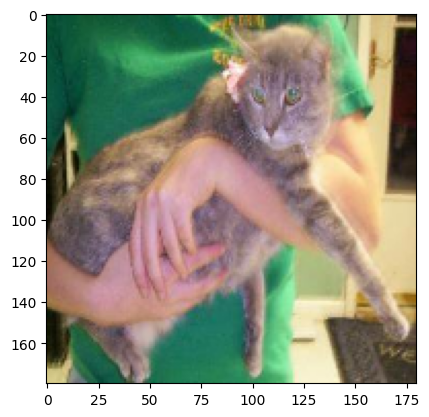

In [ ]:
plt.imshow(sample_batch[10].numpy().astype("uint8"))

**TODO: Visualize other samples in the dataset**

In [ ]:
#your code here

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

#TODO: Define Conv2D with filters=64, kernel_size=3

x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

#TODO:Define MaxPooling2d

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

**Compile the model**

Compile the model for the binary classification task.

In [ ]:
# your code here

**Fitting the model using a `Dataset`**

In [ ]:
#This is a callback that saves the model during training.
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras", #The model will be saved to this file.
        save_best_only=True,  # Only saves the model if the validation loss (val_loss) improves
        monitor="val_loss")   # The model checkpointing is based on the validation loss,
                              # whenever val_loss decreases, the model is saved.

]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.4959 - loss: 0.7327 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5322 - loss: 0.6945 - val_accuracy: 0.5430 - val_loss: 0.6905
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5802 - loss: 0.6890 - val_accuracy: 0.5600 - val_loss: 0.6733
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6041 - loss: 0.6641 - val_accuracy: 0.6120 - val_loss: 0.6484
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6644 - loss: 0.6239 - val_accuracy: 0.6100 - val_loss: 0.6675
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6761 - loss: 0.5924 - val_accuracy: 0.6510 - val_loss: 0.6260
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7281 - loss: 0.5436 - val_accuracy: 0.6440 - val_loss: 0.6427
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.7304 - loss: 0.5253 - val_accuracy: 0.6800 -

**Displaying curves of loss and accuracy during training**

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
#TODO: Evaluate the test_model

### Using data augmentation (Optional)

**Define a data augmentation stage to add to an image model**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

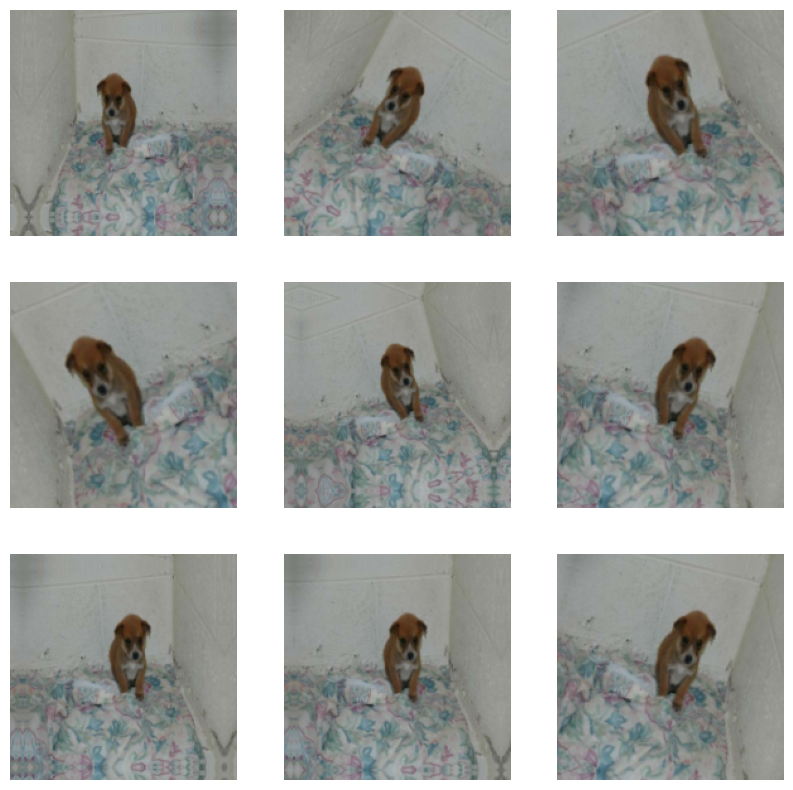

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset:
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
    break

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)         #This line is new - add more data to prevent overfitting
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)            #This line is new - to prevent overfitting
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

Train the new model for 100 epochs and save it in `convnet_from_scratch_with_augmentation.keras` path. 

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8178 - loss: 0.4629
Test accuracy: 0.817
